In [1]:
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Input
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from scipy import stats
import numpy as np

In [2]:
arff_data = arff.loadarff('../data/TimeBasedFeatures-Dataset-15s.arff')
df = pd.DataFrame(arff_data[0])
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,b'CHAT'
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,b'CHAT'
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,b'CHAT'
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,b'CHAT'
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,b'CHAT'


In [3]:
one_hot_labels = pd.get_dummies(df['class1'])
one_hot_labels.head()

,b'BROWSING',b'CHAT',b'FT',b'MAIL',b'P2P',b'STREAMING',b'VOIP',b'VPN-BROWSING',b'VPN-CHAT',b'VPN-FT',b'VPN-MAIL',b'VPN-P2P',b'VPN-STREAMING',b'VPN-VOIP'
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim), stddev=1)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
class Intermediate(layers.Layer):

    def __init__(self, latent_dim=8, name="Intermediate", **kwargs):
        super(Intermediate, self).__init__(name=name, **kwargs)
        self.mean = Dense(latent_dim)
        self.log_var = Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        z_mean = self.mean(inputs)
        z_log_var = self.log_var(inputs)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z
    
    
    def get_config(self):
        config = super().get_config().copy()
        return config

In [6]:
mean = np.mean(df.iloc[:, :-1].values, axis=0, keepdims=True)

In [7]:
std = np.std(df.iloc[:, :-1].values, axis=0, keepdims=True)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = (df.iloc[:, :-1].values - mean)/std
y = one_hot_labels.values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
latent_model = Sequential([
                      Dense(256, input_shape=(X_train.shape[-1],), activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(64, activation='relu'),
                           ], name = 'latent_model')

In [12]:
latent_dim = 8

In [13]:
def build_encoder(inp):
    x = latent_model(inp)
#     z_mean, z_log_var, z = 
    model = Model(inp, Intermediate(latent_dim=latent_dim)(x), name='Encoder')
    return model

In [14]:
inp= Input(shape= (X_train.shape[-1], ), name='Input')
vae_encoder = build_encoder(inp)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [15]:
vae_encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 23)]              0         
_________________________________________________________________
latent_model (Sequential)    (None, 64)                47296     
_________________________________________________________________
Intermediate (Intermediate)  ((None, 8), (None, 8), (N 1040      
Total params: 48,336
Trainable params: 48,336
Non-trainable params: 0
_________________________________________________________________


In [16]:
vae_decoder = Sequential([
                      Dense(64, input_shape=(latent_dim, ), activation='relu'),
                      Dense(128, activation='relu'),
    
                      Dense(256, activation='relu'),
                      Dense(X_train.shape[-1]),
])

In [17]:
vae_encoder = load_model('../models/vae_encoder.h5', custom_objects={"Intermediate": Intermediate}, compile=False, )
vae_decoder = load_model('../models/vae_decoder.h5', compile=False)

In [18]:
z_mean, z_log_var, z = vae_encoder(inp)
vae_autoencoder = Model(inputs = inp, outputs = vae_decoder(z), name = 'AutoEncoder')

In [19]:
vae_autoencoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 23)]              0         
_________________________________________________________________
Encoder (Functional)         [(None, 8), (None, 8), (N 48336     
_________________________________________________________________
sequential (Sequential)      (None, 23)                47831     
Total params: 96,167
Trainable params: 96,167
Non-trainable params: 0
_________________________________________________________________


In [20]:
def custom_loss(y_true, y_predict):
    mean_loss = K.mean(K.square(y_true-y_predict))

    return mean_loss

In [21]:
kl_loss = -5e-4 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae_autoencoder.add_loss(kl_loss, inputs=inp)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
vae_autoencoder.compile(optimizer, loss = custom_loss, metrics = ['accuracy'])

In [30]:
vae_autoencoder.fit(X_train, X_train, batch_size= 10000, epochs= 100)

Epoch 1/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.9059
Epoch 2/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.9075
Epoch 3/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9052
Epoch 4/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 0.9049
Epoch 5/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0035 - accuracy: 0.9090
Epoch 6/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9066
Epoch 7/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0035 - accuracy: 0.9045
Epoch 8/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0035 - accuracy: 0.9053
Epoch 9/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9061
Epoch 10/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9055
Epoch 11/1000
2/2 [

2/2 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9103
Epoch 84/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9155
Epoch 85/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.9120
Epoch 86/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0033 - accuracy: 0.9153
Epoch 87/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 0.9099
Epoch 88/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9130
Epoch 89/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.9122
Epoch 90/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.9150
Epoch 91/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9135
Epoch 92/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9142
Epoch 93/1000
2/2 [=====

2/2 [==============================] - 0s 5ms/step - loss: 0.0038 - accuracy: 0.9207
Epoch 166/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 0.9141
Epoch 167/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9154
Epoch 168/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.9164
Epoch 169/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.9186
Epoch 170/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9163
Epoch 171/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0033 - accuracy: 0.9167
Epoch 172/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0032 - accuracy: 0.9153
Epoch 173/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0032 - accuracy: 0.9166
Epoch 174/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0032 - accuracy: 0.9173
Epoch 175/1000


2/2 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9203
Epoch 248/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.9220
Epoch 249/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.9193
Epoch 250/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9177
Epoch 251/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.9219
Epoch 252/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9200
Epoch 253/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.9207
Epoch 254/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.9209
Epoch 255/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.9230
Epoch 256/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.9222
Epoch 257/1000


2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9258
Epoch 329/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9235
Epoch 330/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9243
Epoch 331/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9244
Epoch 332/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 0.9248
Epoch 333/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9261
Epoch 334/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9241
Epoch 335/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9225
Epoch 336/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9268
Epoch 337/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9222
Epoch 338/1000


2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9271
Epoch 411/1000
2/2 [==============================] - 0s 9ms/step - loss: 0.0027 - accuracy: 0.9259
Epoch 412/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9273
Epoch 413/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9258
Epoch 414/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9279
Epoch 415/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9247
Epoch 416/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9267
Epoch 417/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9229
Epoch 418/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9291
Epoch 419/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 0.9283
Epoch 420/1000


2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9286
Epoch 493/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9287
Epoch 494/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9297
Epoch 495/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9300
Epoch 496/1000
2/2 [==============================] - 0s 8ms/step - loss: 0.0028 - accuracy: 0.9282
Epoch 497/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9296
Epoch 498/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9289
Epoch 499/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9272
Epoch 500/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9286
Epoch 501/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9331
Epoch 502/1000


2/2 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.9282
Epoch 575/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9299
Epoch 576/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9332
Epoch 577/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9296
Epoch 578/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9293
Epoch 579/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0027 - accuracy: 0.9312
Epoch 580/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9290
Epoch 581/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9307
Epoch 582/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9312
Epoch 583/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9284
Epoch 584/1000


2/2 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.9317
Epoch 656/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0027 - accuracy: 0.9336
Epoch 657/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9360
Epoch 658/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9325
Epoch 659/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9316
Epoch 660/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0028 - accuracy: 0.9334
Epoch 661/1000
2/2 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.9337
Epoch 662/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9339
Epoch 663/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0027 - accuracy: 0.9298
Epoch 664/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 0.9345
Epoch 665/1000


2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9310
Epoch 738/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9367
Epoch 739/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0026 - accuracy: 0.9345
Epoch 740/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0025 - accuracy: 0.9322
Epoch 741/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0025 - accuracy: 0.9311
Epoch 742/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9335
Epoch 743/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.9315
Epoch 744/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0025 - accuracy: 0.9337
Epoch 745/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9356
Epoch 746/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 0.9338
Epoch 747/1000


2/2 [==============================] - 0s 6ms/step - loss: 0.0043 - accuracy: 0.9160
Epoch 820/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0043 - accuracy: 0.9170
Epoch 821/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0043 - accuracy: 0.9145
Epoch 822/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.9139
Epoch 823/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.9172
Epoch 824/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.9175
Epoch 825/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 0.9176
Epoch 826/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 0.9186
Epoch 827/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0042 - accuracy: 0.9180
Epoch 828/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0041 - accuracy: 0.9183
Epoch 829/1000


2/2 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.9222
Epoch 902/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.9235
Epoch 903/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.9216
Epoch 904/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.9221
Epoch 905/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.9231
Epoch 906/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.9228
Epoch 907/1000
2/2 [==============================] - 0s 6ms/step - loss: 0.0034 - accuracy: 0.9238
Epoch 908/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.9209
Epoch 909/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0034 - accuracy: 0.9238
Epoch 910/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.9258
Epoch 911/1000


2/2 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.9286
Epoch 983/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.9284
Epoch 984/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 0.9271
Epoch 985/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.9313
Epoch 986/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.9258
Epoch 987/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 0.9269
Epoch 988/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.9280
Epoch 989/1000
2/2 [==============================] - 0s 5ms/step - loss: 0.0031 - accuracy: 0.9278
Epoch 990/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 0.9288
Epoch 991/1000
2/2 [==============================] - 0s 4ms/step - loss: 0.0031 - accuracy: 0.9283
Epoch 992/1000


In [31]:
vae_encoder.save('../models/vae_encoder.h5')
vae_decoder.save('../models/vae_decoder.h5')

(array([2.000e+00, 3.000e+00, 7.000e+00, 4.300e+01, 1.603e+03, 4.122e+04,
        2.310e+02, 3.000e+01, 5.000e+00, 4.000e+00]),
 array([-0.86874943, -0.70526736, -0.5417853 , -0.37830323, -0.21482117,
        -0.0513391 ,  0.11214297,  0.27562503,  0.4391071 ,  0.60258916,
         0.76607123]),
 <BarContainer object of 10 artists>)

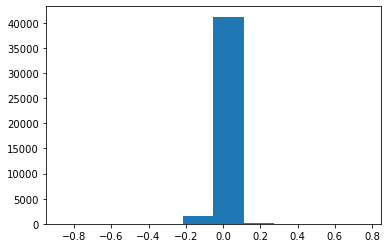

In [33]:
plt.hist( (vae_autoencoder.predict(X_test) - X_test).reshape(-1))